
<script type="text/javascript" src="../_static/linksdl.js"></script>
<div class='alert alert-info'>
**This is a fixed-text formatted version of a Jupyter notebook.**

- Try online [![Binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/gammapy/gammapy-webpage/v0.8?urlpath=lab/tree/analysis_3d.ipynb)
- You can contribute with your own notebooks in this
[GitHub repository](https://github.com/gammapy/gammapy/tree/master/tutorials).
- **Source files:**
[analysis_3d.ipynb](../_static/notebooks/analysis_3d.ipynb) |
[analysis_3d.py](../_static/notebooks/analysis_3d.py)
</div>


# 3D analysis

This tutorial shows how to run a 3D map-based analysis using three example observations of the Galactic center region with CTA.

## Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from gammapy.extern.pathlib import Path
from gammapy.data import DataStore
from gammapy.irf import EnergyDispersion
from gammapy.maps import WcsGeom, MapAxis, Map
from gammapy.cube import MapMaker, PSFKernel, MapFit
from gammapy.cube.models import SkyModel
from gammapy.spectrum.models import PowerLaw
from gammapy.image.models import SkyGaussian, SkyPointSource
from regions import CircleSkyRegion

In [3]:
!gammapy info --no-envvar --no-dependencies --no-system


Gammapy package:

	path                   : /Users/jer/git/gammapy/gammapy 
	version                : 0.8        



## Prepare modeling input data

### Prepare input maps

We first use the `DataStore` object to access the CTA observations and retrieve a list of observations by passing the observations IDs to the `.obs_list()` method:

In [4]:
# Define which data to use
data_store = DataStore.from_dir("$GAMMAPY_DATA/cta-1dc/index/gps/")
obs_ids = [110380, 111140, 111159]
obs_list = data_store.obs_list(obs_ids)

Now we define a reference geometry for our analysis, We choose a WCS based gemoetry with a binsize of 0.02 deg and also define an energy axis: 

In [5]:
energy_axis = MapAxis.from_edges(
    np.logspace(-1., 1., 10), unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(10, 8),
    coordsys="GAL",
    proj="CAR",
    axes=[energy_axis],
)

The `MapMaker` object is initialized with this reference geometry and a field of view cut of 4 deg:

In [6]:
%%time
maker = MapMaker(geom, offset_max=4. * u.deg)
maps = maker.run(obs_list)

CPU times: user 12.8 s, sys: 2.66 s, total: 15.5 s
Wall time: 15.5 s


The maps are prepare by calling the `.run()` method and passing the observation list `obs_list`. The `.run()` method returns a Python `dict` containing a `counts`, `background` and `exposure` map:

In [7]:
print(maps)

{'counts': WcsNDMap

	geom  : WcsGeom 
 	axes  : lon, lat, energy
	shape : (500, 400, 9)
	ndim  : 3
	unit  : '' 
	dtype : float32 
, 'exposure': WcsNDMap

	geom  : WcsGeom 
 	axes  : lon, lat, energy
	shape : (500, 400, 9)
	ndim  : 3
	unit  : 'm2 s' 
	dtype : float32 
, 'background': WcsNDMap

	geom  : WcsGeom 
 	axes  : lon, lat, energy
	shape : (500, 400, 9)
	ndim  : 3
	unit  : '' 
	dtype : float32 
}


This is what the summed counts image looks like:

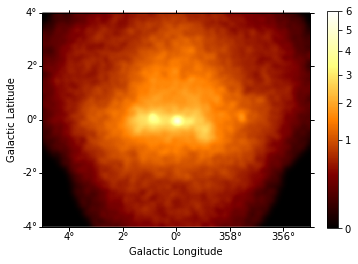

In [8]:
counts = maps["counts"].sum_over_axes()
counts.smooth(width=0.1 * u.deg).plot(stretch="sqrt", add_cbar=True, vmax=6);

And the background image:

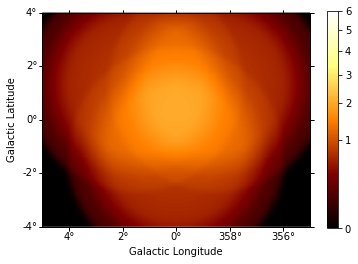

In [9]:
background = maps["background"].sum_over_axes()
background.smooth(width=0.1 * u.deg).plot(
    stretch="sqrt", add_cbar=True, vmax=6
);

We can also compute an excess image just with  a few lines of code:

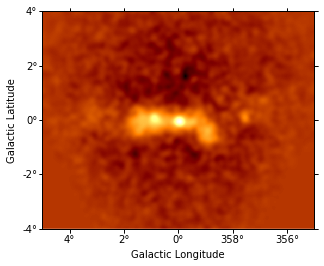

In [10]:
excess = Map.from_geom(geom.to_image())
excess.data = counts.data - background.data
excess.smooth(5).plot(stretch="sqrt");

### Prepare IRFs

To estimate the mean PSF across all observations at a given source position `src_pos`, we use the `obs_list.make_mean_psf()` method:

In [11]:
# mean PSF
src_pos = SkyCoord(0, 0, unit="deg", frame="galactic")
table_psf = obs_list.make_mean_psf(src_pos)

# PSF kernel used for the model convolution
psf_kernel = PSFKernel.from_table_psf(table_psf, geom, max_radius="0.3 deg")

To estimate the mean energy dispersion across all observations at a given source position `src_pos`, we use the `obs_list.make_mean_edisp()` method:

In [12]:
# define energy grid
energy = energy_axis.edges * energy_axis.unit

# mean edisp
edisp = obs_list.make_mean_edisp(
    position=src_pos, e_true=energy, e_reco=energy
)

### Save maps and IRFs to disk

It is common to run the preparation step independent of the likelihood fit, because often the preparation of maps, PSF and energy dispersion is slow if you have a lot of data. We first create a folder:

In [13]:
path = Path("analysis_3d")
path.mkdir(exist_ok=True)

And the write the maps and IRFs to disk by calling the dedicated `.write()` methods:

In [14]:
# write maps
maps["counts"].write(str(path / "counts.fits"), overwrite=True)
maps["background"].write(str(path / "background.fits"), overwrite=True)
maps["exposure"].write(str(path / "exposure.fits"), overwrite=True)

# write IRFs
psf_kernel.write(str(path / "psf.fits"), overwrite=True)
edisp.write(str(path / "edisp.fits"), overwrite=True)

## Likelihood fit

### Reading maps and IRFs
As first step we read in the maps and IRFs that we have saved to disk again:

In [15]:
# read maps
maps = {
    "counts": Map.read(str(path / "counts.fits")),
    "background": Map.read(str(path / "background.fits")),
    "exposure": Map.read(str(path / "exposure.fits")),
}

# read IRFs
psf_kernel = PSFKernel.read(str(path / "psf.fits"))
edisp = EnergyDispersion.read(str(path / "edisp.fits"))

Let's cut out only part of the maps, so that we the fitting step does not take so long:

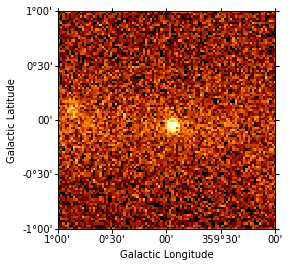

In [16]:
cmaps = {
    name: m.cutout(SkyCoord(0, 0, unit="deg", frame="galactic"), 2 * u.deg)
    for name, m in maps.items()
}
cmaps["counts"].sum_over_axes().plot(stretch="sqrt");

### Fit mask

To select a certain spatial region and/or energy range for the fit we can create a fit mask:

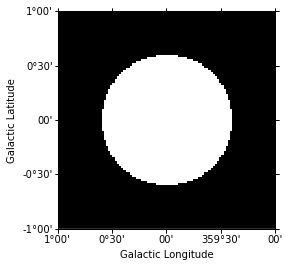

In [17]:
mask = Map.from_geom(cmaps["counts"].geom)

region = CircleSkyRegion(center=src_pos, radius=0.6 * u.deg)
mask.data = mask.geom.region_mask([region])

mask.get_image_by_idx((0,)).plot();

In addition we also exclude the range below 0.3 TeV for the fit:

In [18]:
coords = mask.geom.get_coord()
mask.data &= coords["energy"] > 0.3

### Model fit

No we are ready for the actual likelihood fit. We first define the model as a combination of a point source with a powerlaw:

In [19]:
spatial_model = SkyPointSource(lon_0="0.01 deg", lat_0="0.01 deg")
spectral_model = PowerLaw(
    index=2.2, amplitude="3e-12 cm-2 s-1 TeV-1", reference="1 TeV"
)
model = SkyModel(spatial_model=spatial_model, spectral_model=spectral_model)

Now we set up the `MapFit` object by passing the prepared maps, IRFs as well as the model:

In [20]:
fit = MapFit(
    model=model,
    counts=cmaps["counts"],
    exposure=cmaps["exposure"],
    background=cmaps["background"],
    mask=mask,
    psf=psf_kernel,
    edisp=edisp,
)

No we run the model fit:

In [21]:
%%time
result = fit.run(optimize_opts={"print_level": 1})

FCN = 14281.494006433117 
 TOTAL NCALL = 162 
 NCALLS = 162 
 
 
 EDM = 7.25507095654257e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 par_000_lon_0 
 -4.82863 
 0.219172 
 
 
 
 
 No 
 
 
 1 
 par_001_lat_0 
 -5.2709 
 0.217971 
 
 
 
 
 No 
 
 
 2 
 par_002_index 
 2.37661 
 0.0602493 
 
 
 
 
 No 
 
 
 3 
 par_003_amplitude 
 0.27121 
 0.0149849 
 
 
 
 
 No 
 
 
 4 
 par_004_reference 
 1 
 1 
 
 
 0 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & par 000 $lon_{0}$ & -4.82863 & 0.219172 & & & & & No\\
\hline
1 & par 001 $lat_{0}$ & -5.2709 & 0.217971 & & & & & No\\
\hline
2 & par $002_{index}$ & 2.37661 & 0.0602493 & & & & & No\\
\hline
3 & par $003_{amplitude}$ & 0.27121 & 0.0149849 & & & & & No\\
\hline
4 & par $004_{reference}$ & 1 & 1 & & & 0.0 & & Yes\\
\hline
\end{tabular}

CPU times: user 3.36 s, sys: 58.1 ms, total: 3.42 s
Wall time: 3.42 s


### Check model fit

Finally we check the model fit by cmputing a residual image. For this we first get the number of predicted counts from the fit evaluator:

In [22]:
npred = fit.evaluator.compute_npred()

And compute a residual image:

In [23]:
residual = Map.from_geom(cmaps["counts"].geom)
residual.data = cmaps["counts"].data - npred.data

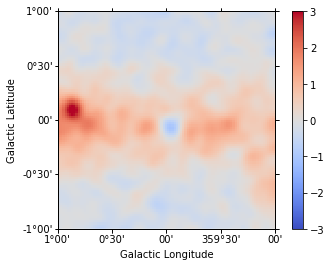

In [24]:
residual.sum_over_axes().smooth(width=0.05 * u.deg).plot(
    cmap="coolwarm", vmin=-3, vmax=3, add_cbar=True
);

Apparently our model should be improved by adding a component for diffuse Galactic emission and at least one second point
source (see exercises at the end of the notebook).

We can also plot the best fit spectrum:

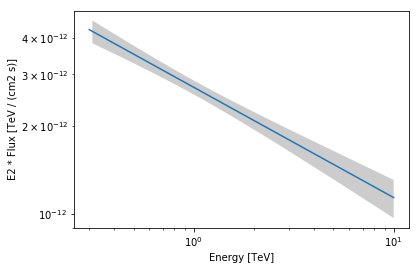

In [25]:
spec = result.model.spectral_model
energy_range = [0.3, 10] * u.TeV
spec.plot(energy_range=energy_range, energy_power=2)
ax = spec.plot_error(energy_range=energy_range, energy_power=2)

## Exercises

* Analyse the second source in the field of view: G0.9+0.1
* Run the model fit with energy dispersion (pass edisp to MapFit)